In [1]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import zuko
from tqdm import tqdm
import seaborn as sns
import pandas as pd

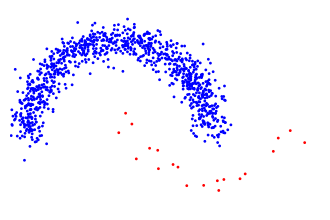

In [3]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = torch.cat(
        [
            torch.pi * torch.rand(n),
            torch.pi * torch.rand(n // 50) + torch.pi,
        ]
    )
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(1000)

plt.figure(figsize=(4, 4))
plt.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
plt.savefig("images/two_moons.png", dpi=300)

In [4]:
nominal = samples[labels == 0]
failure = samples[labels == 1]
failure.shape

torch.Size([20, 2])

In [239]:
# Train single NSF with KL regularization
beta = 0.01
flow_nsf_beta_nominal = zuko.flows.NSF(features=2, hidden_features=(64, 64))
flow_nsf_beta_failure = zuko.flows.NSF(features=2, hidden_features=(64, 64))
nominal_optimizer = torch.optim.Adam(flow_nsf_beta_nominal.parameters(), lr=1e-3)
failure_optimizer = torch.optim.Adam(flow_nsf_beta_failure.parameters(), lr=1e-3)

pbar = tqdm(range(200))
for epoch in pbar:
    nominal_optimizer.zero_grad()
    failure_optimizer.zero_grad()

    loss_nominal = -flow_nsf_beta_nominal().log_prob(nominal).mean()

    loss_nominal.backward()
    nominal_optimizer.step()

    p_dist = flow_nsf_beta_failure()
    q_dist = flow_nsf_beta_nominal()
    p_samples, p_logprobs = p_dist.rsample_and_log_prob((100,))
    q_logprobs = q_dist.log_prob(p_samples)
    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)

    loss_failure = (
        -flow_nsf_beta_failure().log_prob(failure).mean() + beta * kl_divergence
    )
    loss_failure.backward()
    failure_optimizer.step()

    pbar.set_description(
        f"({epoch}) {loss_nominal.detach().item():.3f}, {loss_failure.detach().item():.3f}"
    )

  0%|          | 0/200 [00:00<?, ?it/s]

(199) 0.303, -1.073: 100%|██████████| 200/200 [00:10<00:00, 19.43it/s]


In [282]:
# Train calibrated NSF
beta = 1.0
n_permutations = 5
permutation_size = failure.shape[0] // 2
flow_nsf_beta_calibrated_nominal = zuko.flows.NSF(features=2, hidden_features=(64, 64))
flow_nsf_beta_calibrated_failure = zuko.flows.NSF(
    features=2, context=n_permutations, hidden_features=(64, 64)
)

nominal_optimizer = torch.optim.Adam(
    flow_nsf_beta_calibrated_nominal.parameters(), lr=1e-3
)
failure_optimizer = torch.optim.Adam(
    flow_nsf_beta_calibrated_failure.transform.parameters(), lr=1e-3
)

# Create a set of permuted failure samples
failure_permutations = []
for i in range(n_permutations):
    failure_permutations.append(torch.randperm(failure.shape[0])[:permutation_size])

pbar = tqdm(range(500))
for epoch in pbar:
    nominal_optimizer.zero_grad()
    loss_nominal = -flow_nsf_beta_calibrated_nominal().log_prob(nominal).mean()
    loss_nominal.backward()
    nominal_optimizer.step()

    failure_optimizer.zero_grad()
    total_failure_loss = torch.tensor(0.0)

    for i in range(n_permutations):
        label = torch.zeros(n_permutations)
        label[i] = 1.0
        total_failure_loss += (
            -flow_nsf_beta_calibrated_failure(label)
            .log_prob(failure[failure_permutations[i]])
            .mean()
            / n_permutations
        )

    # # Sample some permutation pairs and compute the cross-entropy
    # n_entropy_pairs = 1
    # entropy_pairs = torch.randint(0, n_permutations, (n_entropy_pairs, 2))
    # for i, j in entropy_pairs:
    #     label1 = torch.zeros(n_permutations)
    #     label2 = torch.zeros(n_permutations)
    #     label1[i] = 1.0
    #     label2[j] = 1.0

    #     p1_samples = flow_nsf_beta_calibrated_failure(label1).rsample((1000,))
    #     ce_p1_p2 = -flow_nsf_beta_calibrated_failure(label2).log_prob(p1_samples).mean()

    #     total_failure_loss += -beta * ce_p1_p2 / n_entropy_pairs

    # Sample some random labels
    n_random_labels = 10
    random_labels = torch.rand(n_random_labels, n_permutations)
    samples = flow_nsf_beta_calibrated_failure(random_labels).rsample((100,))
    kl_p_base = (
        flow_nsf_beta_calibrated_failure(random_labels).log_prob(samples)
        - flow_nsf_beta_calibrated_failure.base(random_labels).log_prob(samples)
    ).mean(dim=0)
    kl_err = kl_p_base - 100 * torch.norm(random_labels, dim=-1) / n_permutations
    total_failure_loss += beta * (kl_err ** 2).mean()

    # Also try to reconstruct the nominal with a zero label
    label = torch.zeros(n_permutations)
    total_failure_loss += (
        -flow_nsf_beta_calibrated_failure(label).log_prob(nominal).mean()
        # / n_permutations
    )

    total_failure_loss.backward()
    failure_optimizer.step()

    pbar.set_description(
        f"({epoch}) {loss_nominal.detach().item():.3f}, {total_failure_loss:.3f}"
    )

  0%|          | 0/500 [00:00<?, ?it/s]

(499) 0.280, 3.974: 100%|██████████| 500/500 [00:53<00:00,  9.39it/s] 


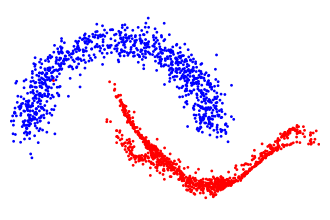

In [283]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
nominal_samples = flow_nsf_beta_nominal().sample((1_000,))
nominal_labels = torch.tensor([0.0]).expand(1_000)
failure_samples = flow_nsf_beta_failure().sample((1_000,))
failure_labels = torch.tensor([1.0]).expand(1_000)
samples = torch.cat((nominal_samples, failure_samples), axis=0)
labels = torch.cat((nominal_labels, failure_labels), axis=0)
ax.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
# plt.savefig('images/two_moons_nsf_context_beta.png', dpi=300)

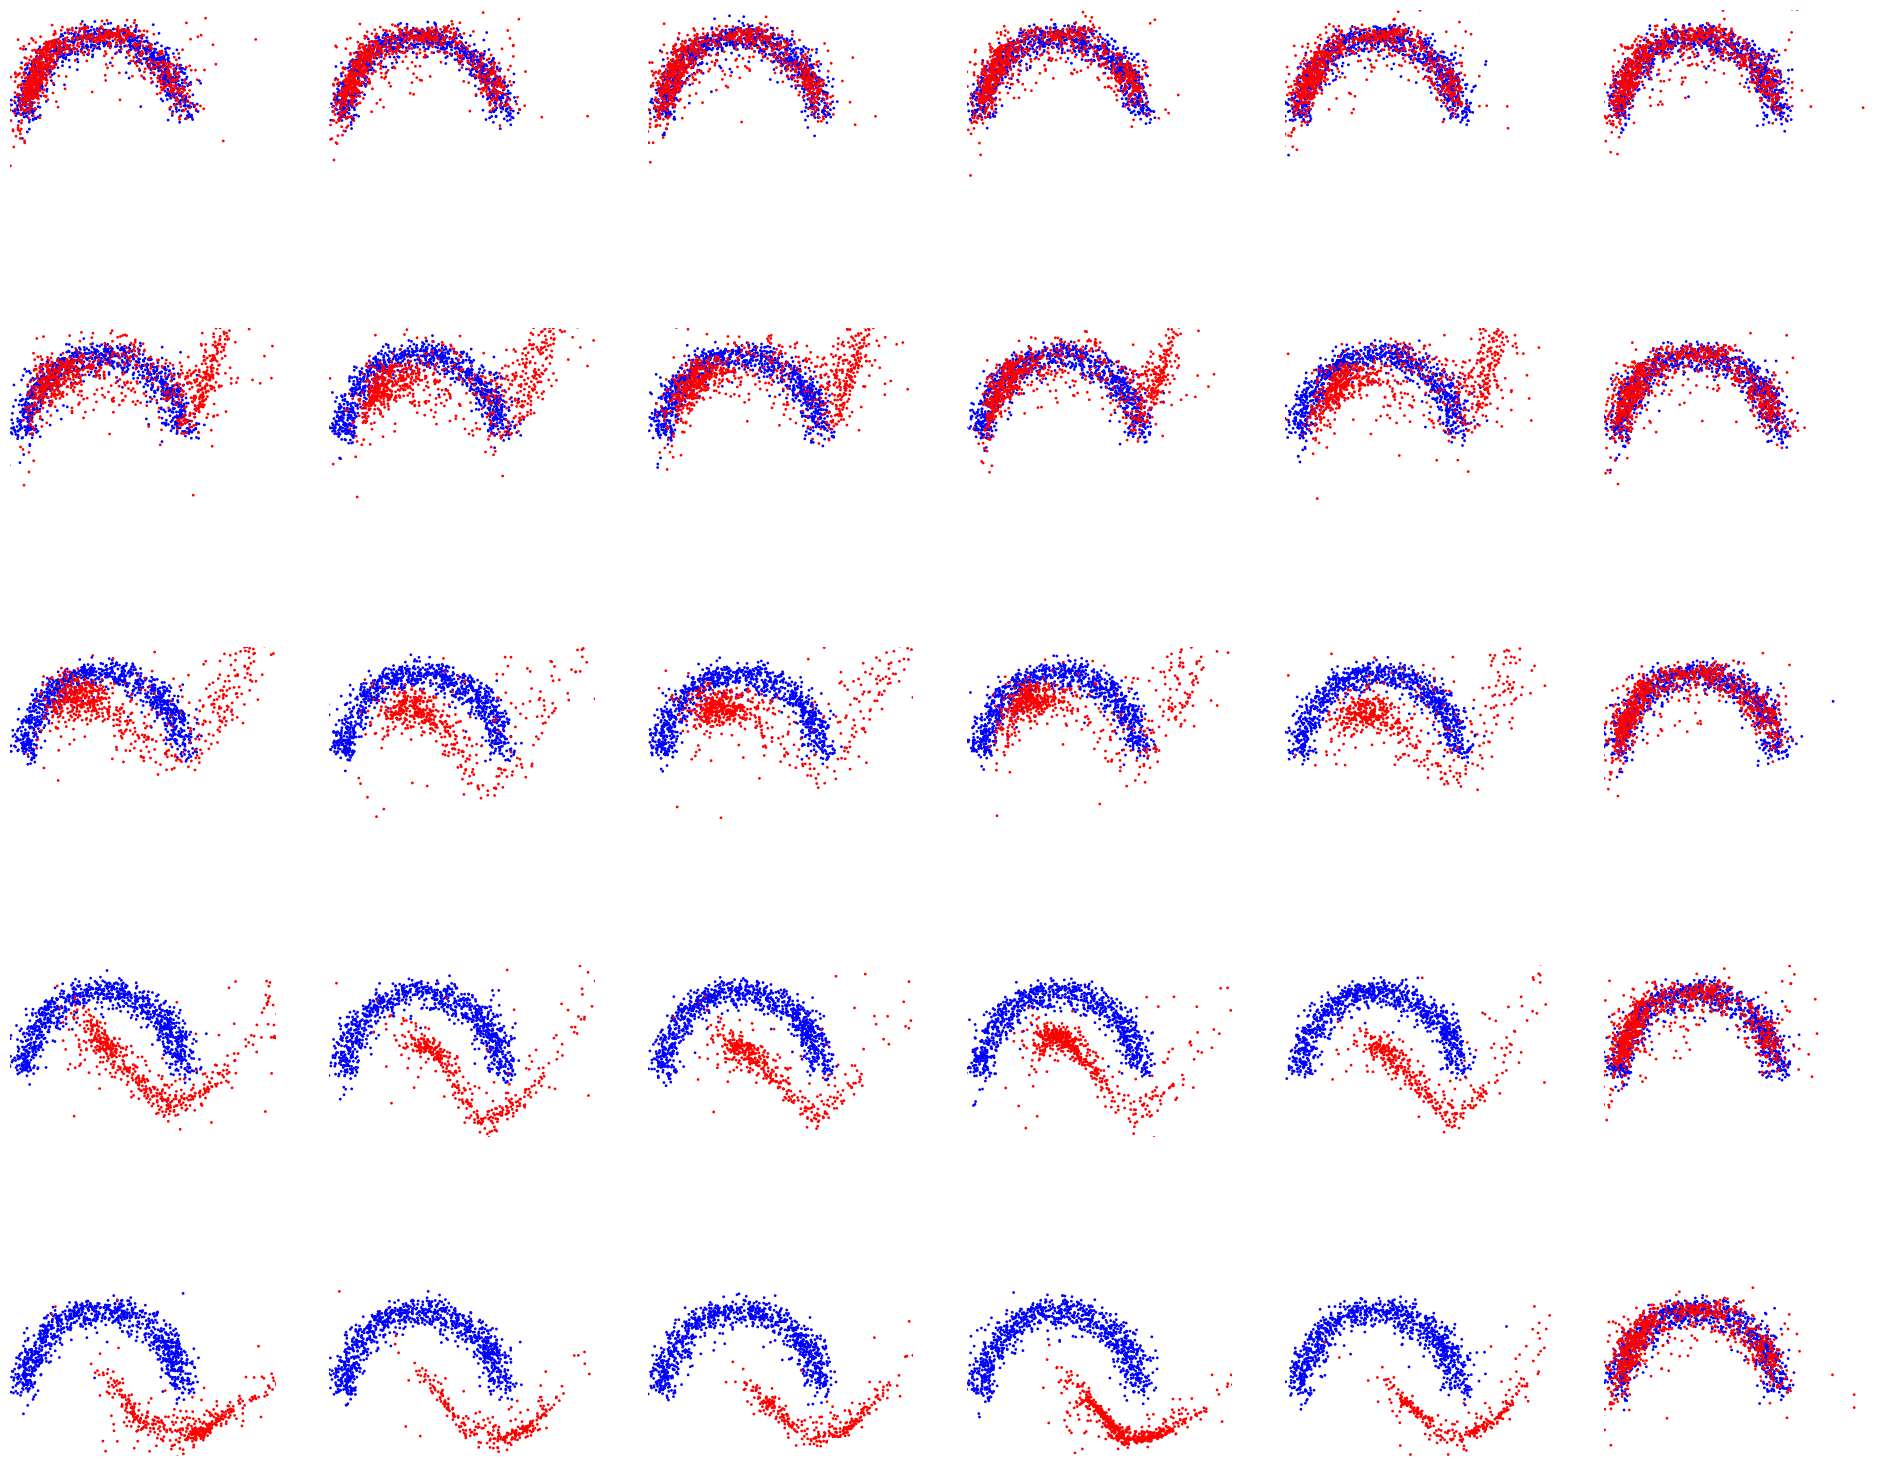

In [284]:
n_steps = 5
_, axs = plt.subplots(n_steps, 1 + n_permutations, figsize=(4 * (1 + n_permutations), 4 * n_steps))
for row, j in enumerate(torch.linspace(0, 1, n_steps)):
    for i in range(n_permutations):
        label = torch.zeros(n_permutations)
        label[i] = j

        nominal_samples = flow_nsf_beta_calibrated_nominal().sample((1_000,))
        nominal_labels = torch.tensor([0.0]).expand(1_000)
        failure_samples = flow_nsf_beta_calibrated_failure(label).sample((1_000,))
        failure_labels = torch.tensor([1.0]).expand(1_000)

        samples = torch.cat((nominal_samples, failure_samples), axis=0)
        labels = torch.cat((nominal_labels, failure_labels), axis=0)
        axs[row, i].scatter(*samples.T, s=1, c=labels, cmap="bwr")
        # Turn off axis ticks
        axs[row, i].set_xticks([])
        axs[row, i].set_yticks([])
        axs[row, i].axis("off")
        axs[row, i].set_ylim([-1.1, 1.1])
        axs[row, i].set_xlim([-1.7, 1.7])
        # Equal aspect
        axs[row, i].set_aspect("equal")
        # plt.savefig('images/two_moons_cnf_stacked.png', dpi=300)

    i = -1
    label = torch.zeros(n_permutations)
    nominal_samples = flow_nsf_beta_calibrated_nominal().sample((1_000,))
    nominal_labels = torch.tensor([0.0]).expand(1_000)
    failure_samples = flow_nsf_beta_calibrated_failure(label).sample((1_000,))
    failure_labels = torch.tensor([1.0]).expand(1_000)

    samples = torch.cat((nominal_samples, failure_samples), axis=0)
    labels = torch.cat((nominal_labels, failure_labels), axis=0)
    axs[row, i].scatter(*samples.T, s=1, c=labels, cmap="bwr")
    # Turn off axis ticks
    axs[row, i].set_xticks([])
    axs[row, i].set_yticks([])
    axs[row, i].axis("off")
    axs[row, i].set_ylim([-1.1, 1.1])
    axs[row, i].set_xlim([-1.7, 1.7])
    # Equal aspect
    axs[row, i].set_aspect("equal")

plt.savefig('images/two_moons_cnf_calibrated_range.png', dpi=300)

In [300]:
# Calibration step: can we optimize the label to maximize performance on the full set?
label = torch.zeros(n_permutations, requires_grad=True)
label_optimizer = torch.optim.Adam([label], lr=1e-3)

pbar = tqdm(range(1000))
for epoch in pbar:
    label_optimizer.zero_grad()
    loss = -flow_nsf_beta_calibrated_failure(label).log_prob(failure).mean()
    loss.backward()
    label_optimizer.step()
    pbar.set_description(f"({epoch}) {loss.detach().item():.3f}")

print(label.detach())

(999) 0.858: 100%|██████████| 1000/1000 [00:08<00:00, 116.91it/s]

tensor([-0.0835, -0.2352,  0.2938,  0.4734,  0.4486])


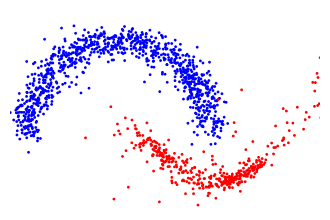

In [301]:
nominal_samples = flow_nsf_beta_calibrated_nominal().sample((1_000,))
nominal_labels = torch.tensor([0.0]).expand(1_000)
failure_samples = flow_nsf_beta_calibrated_failure(label).sample((1_000,))
failure_labels = torch.tensor([1.0]).expand(1_000)

samples = torch.cat((nominal_samples, failure_samples), axis=0)
labels = torch.cat((nominal_labels, failure_labels), axis=0)

_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
plt.savefig('images/two_moons_nsf_calibrated.png', dpi=300)